In [268]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import(TimeSeriesSplit,KFold,ShuffleSplit,StratifiedKFold,GroupShuffleSplit,GroupKFold, StratifiedShuffleSplit)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
pd.set_option('display.max_columns',30)

In [2]:
data = pd.read_excel('C:\\Users\\shahg_000\\Downloads\\data.xlsx')
df=data.set_index('Date')

In [277]:
TrainingSet=df.loc[:'2002-12-31',:]
TestSet=df.loc['2003-01-01':,:]

Wall time: 26.9 ms


In [4]:
def Stacking(toBeStacked,p):
    n=p+1
    stackedF=pd.DataFrame()
    temp=np.zeros(shape=(1,n))
    for cnum in range(toBeStacked.shape[1]):
        temp1=np.zeros(shape=(1,n))
        for rnum in range(n,len(toBeStacked)+1):
            temp1=np.append(temp1,[np.flip(np.array(toBeStacked.iloc[rnum-n:rnum,cnum]))],axis=0)
        temp1=np.delete(temp1,(0),axis=0)
        temp=np.append(temp,temp1,axis=0)
    return(pd.DataFrame(np.delete(temp,(0),axis=0)))

In [5]:
def DummyVariables(toBeDummy):
    p=int(toBeDummy.shape[0]/30)
    finalDataframe = pd.DataFrame()
    for i in range(0,29):
        dummyframes = pd.DataFrame(data = 0, index=range(p),columns=range(28))
        dummyframes.insert(i, "DV"+str(i), 1)
        finalDataframe = finalDataframe.append(dummyframes)
    dvAllZero = pd.DataFrame(data = 0, index=range(p),columns=range(28))
    finalDataframe = finalDataframe.append(dvAllZero, ignore_index=True)
    finalDataframe.drop(finalDataframe.iloc[:, 0:28], inplace = True, axis = 1) 
    finalDataframe = finalDataframe.fillna(0)
    return(pd.concat([toBeDummy, finalDataframe], axis=1))

In [278]:
%%time
TrainingStacked=Stacking(TrainingSet,90)
TestStacked=Stacking(TestSet,90)

Wall time: 2min 27s


In [9]:
TrainingDummyStacked=DummyVariables(TrainingStacked)
TestDummyStacked=DummyVariables(TestStacked)

C:\Users\shahg_000\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [483]:
print(TrainingDummyStacked.head())
print(TrainingDummyStacked.describe().transpose())

          0         1         2         3         4         5         6  \
0  0.011429  0.000000  0.009238 -0.002317 -0.002312 -0.004608  0.039865   
1  0.037909  0.011429  0.000000  0.009238 -0.002317 -0.002312 -0.004608   
2 -0.008791  0.037909  0.011429  0.000000  0.009238 -0.002317 -0.002312   
3 -0.006645 -0.008791  0.037909  0.011429  0.000000  0.009238 -0.002317   
4  0.015436 -0.006645 -0.008791  0.037909  0.011429  0.000000  0.009238   

          7         8         9        10        11        12        13  \
0  0.024214 -0.028988 -0.016529 -0.009324  0.000000  0.023475  0.019185   
1  0.039865  0.024214 -0.028988 -0.016529 -0.009324  0.000000  0.023475   
2 -0.004608  0.039865  0.024214 -0.028988 -0.016529 -0.009324  0.000000   
3 -0.002312 -0.004608  0.039865  0.024214 -0.028988 -0.016529 -0.009324   
4 -0.002317 -0.002312 -0.004608  0.039865  0.024214 -0.028988 -0.016529   

         14  ...  DV21  DV22  DV23  DV24  DV25  DV26  DV27  DV28  DV3  DV4  \
0  0.014634  ...   0

In [61]:
y=TrainingDummyStacked.loc[:,0]
X=TrainingDummyStacked.drop([0],axis=1)
y_test=TestDummyStacked.loc[:,0]
X_test=TestDummyStacked.drop([0],axis=1)

In [259]:
%%time
k_folds=[3,5,7,9]
temp1=[]
for i in k_folds:    
    C_range = np.logspace(-2, 0, 5)
    gamma_range = np.logspace(-5, -1, 5)
    param_grid = dict(gamma=gamma_range, C=C_range)
    cv = TimeSeriesSplit(n_splits=i)
    grid = GridSearchCV(SVR(kernel='rbf',cache_size=5000,epsilon=0.1), param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X, y)
    print([i,grid.best_params_, grid.best_score_])
    temp1.append([i,grid.best_params_, grid.best_score_])

[3, {'C': 0.31622776601683794, 'gamma': 0.001}, -0.000506029791900988]
[5, {'C': 0.01, 'gamma': 0.1}, -0.0004895798377606294]
[7, {'C': 0.01, 'gamma': 1e-05}, -0.0004979474879402921]
[9, {'C': 0.31622776601683794, 'gamma': 0.001}, -0.0004938671036207112]
Wall time: 18min 4s


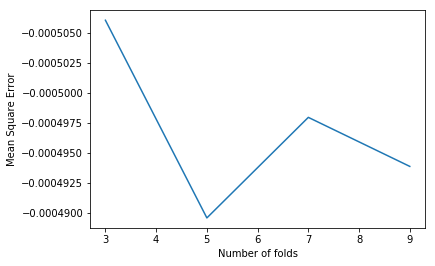

Minimum MSE corresponds to k_folds= 5
Optimal Hyperparamaters: {'C': 0.01, 'gamma': 0.1}


In [484]:
plt.plot(np.array(temp1)[:,0],np.array(temp1)[:,2])
plt.ylim(plt.ylim()[::-1])
plt.xlabel('Number of folds')
plt.ylabel('Mean Square Error')
plt.show()
print("Minimum MSE corresponds to k_folds=", temp1[1][0])
print("Optimal Hyperparamaters:", temp1[1][1])

In [485]:
%%time
rSVR = SVR(kernel='rbf', gamma=0.1, C=0.01, cache_size=5000, epsilon=0.1)
rSVR.fit(X, y)
print("R squared of Train Set: ",rSVR.score(X,y))
print("R squared of Test Set: ",rSVR.score(X_test,y_test))
print("MSE of Train Set: ",mean_squared_error(y,rSVR.predict(X)))
print("MSE of Test Set: ",mean_squared_error(y_test,rSVR.predict(X_test)))
rSVR

R squared of Train Set:  -0.16540110796452992
R squared of Test Set:  -0.12097083914672457
MSE of Train Set:  0.0004913612356904043
MSE of Test Set:  0.0005456991905597548
Wall time: 16.1 s


SVR(C=0.01, cache_size=5000, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [262]:
%%time
Rfr=RandomForestRegressor(n_estimators=100,criterion='mse',max_features='sqrt',n_jobs=-1, warm_start=True,random_state=5)
Rfr.fit(X,y)

Wall time: 3min 9s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=5, verbose=0, warm_start=True)

In [263]:
print("R squared of Train Set: ",Rfr.score(X,y))
print("R squared of Test Set: ",Rfr.score(X_test,y_test))
print("MSE of Train Set: ",mean_squared_error(y,Rfr.predict(X)))
print("MSE of Test Set: ",mean_squared_error(y_test,Rfr.predict(X_test)))

R squared of Train Set:  0.8663007648026346
R squared of Test Set:  -0.02394235961471325
MSE of Train Set:  5.6370824575738186e-05
MSE of Test Set:  0.0004984648104199768


In [243]:
%%time
Gbr=GradientBoostingRegressor(learning_rate=0.1,n_estimators=300, max_depth=3, random_state=5, warm_start=True)
Gbr.fit(X,y)

Wall time: 6min 55s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=5,
             subsample=1.0, verbose=0, warm_start=True)

In [232]:
# print(Gbr.score(X,y))
# print(Gbr.score(X_test,y_test))
# print(mean_squared_error(y,Gbr.predict(X)))
# print(mean_squared_error(y_test,Gbr.predict(X_test)))
# # lr 0.1/100/2

0.02844810140481413
-0.025838709743775556
0.0004096297302006843
0.0004993879715712829


In [234]:
# print(Gbr.score(X,y))
# print(Gbr.score(X_test,y_test))
# print(mean_squared_error(y,Gbr.predict(X)))
# print(mean_squared_error(y_test,Gbr.predict(X_test)))
# # lr 0.01/100/2

0.0076761714315485285
-0.0063792026183047135
0.00041838767723676086
0.0004899148997337101


In [238]:
# print(Gbr.score(X,y))
# print(Gbr.score(X_test,y_test))
# print(mean_squared_error(y,Gbr.predict(X)))
# print(mean_squared_error(y_test,Gbr.predict(X_test)))
# # lr 0.01/200/2

0.012042661984975833
-0.009470666469451272
0.0004165466594281286
0.0004914198535311697


In [240]:
# print(Gbr.score(X,y))
# print(Gbr.score(X_test,y_test))
# print(mean_squared_error(y,Gbr.predict(X)))
# print(mean_squared_error(y_test,Gbr.predict(X_test)))
# # lr 0.01/100/3

0.012374924831221268
-0.005003387412566118
0.0004164065693925267
0.0004892451398988308


In [242]:
# print(Gbr.score(X,y))
# print(Gbr.score(X_test,y_test))
# print(mean_squared_error(y,Gbr.predict(X)))
# print(mean_squared_error(y_test,Gbr.predict(X_test)))
# # lr 0.1/100/3

0.04856309400813952
-0.048377609760004166
0.0004011487638158693
0.000510360120948804


In [244]:
# print(Gbr.score(X,y))
# print(Gbr.score(X_test,y_test))
# print(mean_squared_error(y,Gbr.predict(X)))
# print(mean_squared_error(y_test,Gbr.predict(X_test)))
# # lr 0.1/300/3

0.09398990350033098
-0.07803236668610647
0.0003819957244948915
0.0005247963366697575


In [256]:
%%time
k_folds=[3,5,7,9]
temp=[]
for i in k_folds:    
    learning_rate_r=np.array([0.01,0.1])
    n_estimators_r = np.array([50,75,100])
    param_grid = dict(learning_rate=learning_rate_r, n_estimators=n_estimators_r)
    cv = TimeSeriesSplit(n_splits=i)
    grid = GridSearchCV(GradientBoostingRegressor(max_depth=3, random_state=5, warm_start=True), param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X, y)
    print([i,grid.best_params_, grid.best_score_])
    temp.append([i,grid.best_params_, grid.best_score_])

[3, {'learning_rate': 0.1, 'n_estimators': 100}, -0.0004150851579774712]
[5, {'learning_rate': 0.1, 'n_estimators': 100}, -0.00040423969016882143]
[7, {'learning_rate': 0.1, 'n_estimators': 100}, -0.0004116567062804378]
[9, {'learning_rate': 0.1, 'n_estimators': 100}, -0.00041156627807222875]
Wall time: 1h 16min 15s


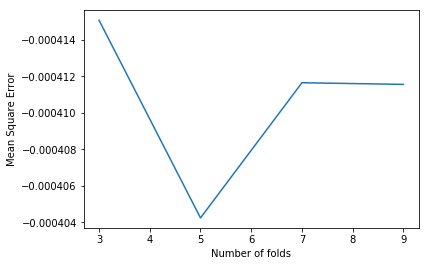

Minimum MSE corresponds to k_folds= 5
Optimal Hyperparamaters: {'learning_rate': 0.1, 'n_estimators': 100}


In [489]:
plt.plot(np.array(temp)[:,0],np.array(temp)[:,2])
plt.ylim(plt.ylim()[::-1])
plt.xlabel('Number of folds')
plt.ylabel('Mean Square Error')
plt.show()
print("Minimum MSE corresponds to k_folds=", temp[1][0])
print("Optimal Hyperparamaters:", temp[1][1])

In [258]:
%%time
Gbr=GradientBoostingRegressor(learning_rate=0.1,n_estimators=100, max_depth=3, random_state=5, warm_start=True)
Gbr.fit(X,y)
print("R squared of Train Set: ",Gbr.score(X,y))
print("R squared of Test Set: ",Gbr.score(X_test,y_test))
print("MSE of Train Set: ",mean_squared_error(y,Gbr.predict(X)))
print("MSE of Test Set: ",mean_squared_error(y_test,Gbr.predict(X_test)))

R squared of Train Set:  0.04856309400813952
R squared of Test Set:  -0.048377609760004166
MSE of Train Set:  0.0004011487638158693
MSE of Test Set:  0.000510360120948804
Wall time: 2min 9s


In [490]:
Gbr

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=5,
             subsample=1.0, verbose=0, warm_start=True)

In [264]:
print("Radial Kernel : MSE of Test Set: ",mean_squared_error(y_test,rSVR.predict(X_test)))
print("Random Forest : MSE of Test Set: ",mean_squared_error(y_test,Rfr.predict(X_test)))
print("Boosted Trees : MSE of Test Set: ",mean_squared_error(y_test,Gbr.predict(X_test)))

Radial Kernel : MSE of Test Set:  0.0005456991905597548
Random Forest : MSE of Test Set:  0.0004984648104199768
Boosted Trees : MSE of Test Set:  0.000510360120948804


## Q.7 Trading Strategy

In [408]:
jump=int(len(y_test)/30)
vec=np.array(y_test)
y_test_jump=[]
for i in range(0,jump):
    temp_bit=vec[::jump,]
    y_test_jump.append(temp_bit)
    vec=np.delete(vec,0)
y_test_true=pd.DataFrame(y_test_jump)

y_pred=Rfr.predict(X_test)
jump=int(len(y_pred)/30)
vec=np.array(y_pred)
y_pred_jump=[]
for i in range(0,jump):
    temp_bit=vec[::jump,]
    y_pred_jump.append(temp_bit)
    vec=np.delete(vec,0)
y_test_pred=pd.DataFrame(y_pred_jump)

y_test_pred.columns=TestSet.columns.values
y_test_true.columns=TestSet.columns.values

In [395]:
def splitter_func(n_trade):    
#     n_trade=5
    splitter=y_test_pred
    split_pred=[]
    for i in range(int(len(splitter)/n_trade)):
        split_pred.append(np.sum(np.array(splitter.iloc[i*n_trade:i*n_trade+n_trade-1]),axis=0))
    split_pred_df=pd.DataFrame(split_pred)
    split_pred_df.columns=TestSet.columns.values
    return split_pred_df

In [409]:
df2 = y_test_pred
nlargest = 5
order = np.argsort(-df2.values, axis=1)[:, :nlargest]
result_max = pd.DataFrame(df2.columns[order], columns=['top{}'.format(i) for i in range(1, nlargest+1)],index=df2.index)

df2 = y_test_pred
nlargest = 5
order = np.argsort(df2.values, axis=1)[:, :nlargest]
result_min = pd.DataFrame(df2.columns[order], columns=['top{}'.format(i) for i in range(1, nlargest+1)],index=df2.index)

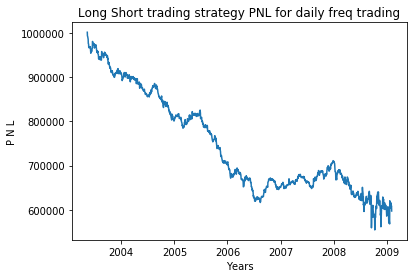

Daily trading Final portfolio value : 597257.2306657671


In [491]:
pnl=[]
port=1000000
for i in range(0,len(result_max)):
    perstock=0.1*port
    max_5=np.exp(np.array(y_test_true.loc[i,np.array(result_max.iloc[i])]))-1
    min_5=np.exp(np.array(y_test_true.loc[i,np.array(result_min.iloc[i])]))-1
    daily_p=0
    daily_p=sum(perstock*max_5)-sum(perstock*min_5)
    port=port+daily_p-port*0.0005
    pnl.append(port)
dates_test=np.delete(np.array(TestSet.index),range(0,90))
plt.plot(dates_test,pnl)
plt.ylabel('P N L')
plt.xlabel('Years')
plt.title('Long Short trading strategy PNL for daily freq trading')
plt.show()
print("Daily trading Final portfolio value :",port)

In [469]:
def trading_strategy(n_trade):
    
    input_df=splitter_func(y_test_pred,n_trade)
    input_df_true=splitter_func(y_test_true,n_trade)
    
    df2 = input_df
    nlargest = 5
    order = np.argsort(-df2.values, axis=1)[:, :nlargest]
    result_max = pd.DataFrame(df2.columns[order], columns=['top{}'.format(i) for i in range(1, nlargest+1)],index=df2.index)

    df2 = input_df
    nlargest = 5
    order = np.argsort(df2.values, axis=1)[:, :nlargest]
    result_min = pd.DataFrame(df2.columns[order], columns=['top{}'.format(i) for i in range(1, nlargest+1)],index=df2.index)

    pnl=[]
    port=1000000
    for i in range(0,len(result_max)):
        perstock=0.1*port
        max_5=np.exp(np.array(input_df_true.loc[i,np.array(result_max.iloc[i])]))-1
        min_5=np.exp(np.array(input_df_true.loc[i,np.array(result_min.iloc[i])]))-1
        daily_p=0
        daily_p=sum(perstock*max_5)-sum(perstock*min_5)
        port=port+daily_p-port*0.0005
        pnl.append(port)
    print(n_trade," day freq. trading : Final portfolio value :",port)
    dates_test=np.delete(np.array(TestSet.index),range(0,90))[::n_trade]
    return port,pnl,dates_test

2  day freq. trading : Final portfolio value : 811641.489175154
3  day freq. trading : Final portfolio value : 1177469.3319886206
4  day freq. trading : Final portfolio value : 668238.6856799033
5  day freq. trading : Final portfolio value : 581070.0626878216
10  day freq. trading : Final portfolio value : 293750.1876725432
15  day freq. trading : Final portfolio value : 270585.7220611559
20  day freq. trading : Final portfolio value : 279836.6908005289


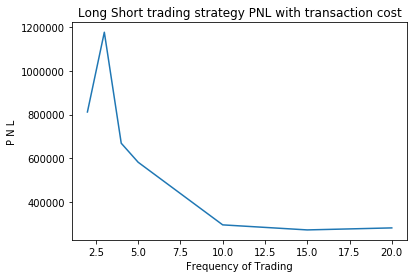

In [472]:
pft=[]
days=[2,3,4,5,10,15,20]
for i in days:
    pft.append(trading_strategy(i))
plt.plot(days,np.array(pft)[:,0])
plt.ylabel('P N L')
plt.xlabel('Frequency of Trading')
plt.title('Long Short trading strategy PNL with transaction cost')
plt.show()

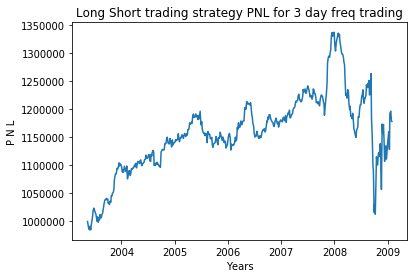

3 day freq. trading : Final portfolio value : 1177469.3319886206


In [476]:
plt.plot(np.array(pft)[1,2],np.array(pft)[1,1])
plt.ylabel('P N L')
plt.xlabel('Years')
plt.title('Long Short trading strategy PNL for 3 day freq trading')
plt.show()
print("3 day freq. trading : Final portfolio value :",np.array(pft)[1,0])

# END